# BONUS: MBERT Model for DSK Banking Question Classification
## Google Colab Notebook for Advanced Deep Learning Approach

## SECTION 1: SETUP AND INSTALLATIONS

In [10]:
#!pip install transformers datasets torch torchvision torchaudio
#!pip install accelerate
#!pip install scikit-learn pandas numpy matplotlib seaborn
#!pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                         TrainingArguments, Trainer, EarlyStoppingCallback)
from datasets import Dataset as HFDataset
import warnings
warnings.filterwarnings('ignore')

# Disable wandb
import os
os.environ["WANDB_DISABLED"] = "true"

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("BONUS: MBERT MODEL FOR BULGARIAN TEXT CLASSIFICATION")
print("=" * 60)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")



BONUS: MBERT MODEL FOR BULGARIAN TEXT CLASSIFICATION
Using device: cuda
   GPU: Tesla T4
   Memory: 14.7 GB


## SECTION 2: DATA PREPARATION

In [12]:
print("\nLOADING AND PREPARING DATA")
print("-" * 40)

# File upload widget for Google Colab
from google.colab import files
import io

print("Please upload your CSV files:")
print("   1. Upload train_data.csv")
print("   2. Upload test_data.csv")

# Upload train_data.csv
print("\nUpload train_data.csv:")
uploaded_train = files.upload()
train_filename = list(uploaded_train.keys())[0]
print(f"Uploaded: {train_filename}")

# Upload test_data.csv
print("\nUpload test_data.csv:")
uploaded_test = files.upload()
test_filename = list(uploaded_test.keys())[0]
print(f"Uploaded: {test_filename}")

# Load the datasets
print("\nLoading datasets...")
try:
    train_df = pd.read_csv(train_filename, encoding='utf-8')
    test_df = pd.read_csv(test_filename, encoding='utf-8')
    print(f"Data loaded successfully!")
    print(f"   Training samples: {len(train_df)}")
    print(f"   Test samples: {len(test_df)}")
    print(f"   Classes: {train_df['department_target'].nunique()}")

    # Display first few rows to verify
    print(f"\nTrain data preview:")
    print(train_df[['question_cleaned', 'department_target']].head(3))

except Exception as e:
    print(f"Error loading data: {e}")
    raise e

# Data exploration
print(f"\nClass Distribution:")
class_dist = train_df['department_target'].value_counts()
for i, (dept, count) in enumerate(class_dist.items(), 1):
    percentage = (count / len(train_df)) * 100
    print(f"   {i:2d}. {dept[:30]:<30} {count:4d} ({percentage:5.1f}%)")

# Prepare labels
label_encoder = LabelEncoder()
train_df['labels'] = label_encoder.fit_transform(train_df['department_target'])
test_df['labels'] = label_encoder.transform(test_df['department_target'])

num_labels = len(label_encoder.classes_)
id2label = {i: label for i, label in enumerate(label_encoder.classes_)}
label2id = {label: i for i, label in enumerate(label_encoder.classes_)}

print(f"\n Label Encoding:")
print(f"   Number of classes: {num_labels}")
print(f"   Sample mapping: {list(id2label.items())[:3]}...")


LOADING AND PREPARING DATA
----------------------------------------
Please upload your CSV files:
   1. Upload train_data.csv
   2. Upload test_data.csv

Upload train_data.csv:


Saving train_data.csv to train_data (6).csv
Uploaded: train_data (6).csv

Upload test_data.csv:


Saving test_data.csv to test_data (6).csv
Uploaded: test_data (6).csv

Loading datasets...
Data loaded successfully!
   Training samples: 1565
   Test samples: 392
   Classes: 13

Train data preview:
                                    question_cleaned  \
0  може ли клиент да използва само интернет банки...   
1  въвеждам номер на лк и получавам грешка: полет...   
2                           служител светослав симов   

           department_target  
0  Пазар Ежедневно банкиране  
1                      Други  
2                      Други  

Class Distribution:
    1. Пазар Ежедневно банкиране       458 ( 29.3%)
    2. Други                           254 ( 16.2%)
    3. Пазар Жилищни и ипотечни креди  215 ( 13.7%)
    4. Пазар Потребителско кредитиран  115 (  7.3%)
    5. Пазар Разсрочени плащания        96 (  6.1%)
    6. Пазар Малък бизнес               76 (  4.9%)
    7. ДИРЕКЦИЯ БАНКОВИ ОПЕРАЦИИ        66 (  4.2%)
    8. Пазар Спестяване и инвестиции    66 (  4.2%)
    9. Няколко

## SECTION 3: MBERT MODEL SETUP

In [14]:
print("\nSETTING UP MBERT MODEL")
print("-" * 40)

# Model configuration
MODEL_NAME = "bert-base-multilingual-cased"
MAX_LENGTH = 128  # Adjust based on your text length analysis

print(f"Model Configuration:")
print(f"   Model: {MODEL_NAME}")
print(f"   Max length: {MAX_LENGTH}")
print(f"   Number of labels: {num_labels}")

# Load tokenizer and model
print("Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

print(f"Model loaded successfully!")
print(f"   Model parameters: {model.num_parameters():,}")



SETTING UP MBERT MODEL
----------------------------------------
Model Configuration:
   Model: bert-base-multilingual-cased
   Max length: 128
   Number of labels: 13
Loading tokenizer and model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
   Model parameters: 177,863,437


## SECTION 4: DATA PREPROCESSING AND TOKENIZATION

In [16]:
print("\nTOKENIZING TEXT DATA")
print("-" * 40)

def tokenize_function(examples):
    """Tokenize text for BERT"""
    return tokenizer(
        examples['question_cleaned'],
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

# Create HuggingFace datasets
train_dataset = HFDataset.from_pandas(train_df[['question_cleaned', 'labels']])
test_dataset = HFDataset.from_pandas(test_df[['question_cleaned', 'labels']])

# Tokenize datasets
print("Tokenizing training data...")
train_dataset = train_dataset.map(tokenize_function, batched=True)

print("Tokenizing test data...")
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

print(f"Tokenization completed!")
print(f"   Train dataset size: {len(train_dataset)}")
print(f"   Test dataset size: {len(test_dataset)}")

# Sample tokenization check
sample_text = train_df['question_cleaned'].iloc[0]
sample_tokens = tokenizer(sample_text, truncation=True, max_length=MAX_LENGTH)
print(f"\nSample tokenization:")
print(f"   Original: {sample_text}")
print(f"   Tokens: {len(sample_tokens['input_ids'])}")
print(f"   First 10 token IDs: {sample_tokens['input_ids'][:10]}")


TOKENIZING TEXT DATA
----------------------------------------
Tokenizing training data...


Map:   0%|          | 0/1565 [00:00<?, ? examples/s]

Tokenizing test data...


Map:   0%|          | 0/392 [00:00<?, ? examples/s]

Tokenization completed!
   Train dataset size: 1565
   Test dataset size: 392

Sample tokenization:
   Original: може ли клиент да използва само интернет банкирането dsk online?
   Tokens: 18
   First 10 token IDs: [101, 13076, 33190, 551, 10783, 28252, 10405, 47913, 14847, 51754]


## SECTION 5: TRAINING CONFIGURATION

In [18]:
print("\n TRAINING CONFIGURATION")
print("-" * 40)

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['labels']),
    y=train_df['labels']
)
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class weights calculated for imbalanced data")
print(f"   Weight range: {class_weights.min():.3f} - {class_weights.max():.3f}")

# Custom trainer with class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir='./mbert_banking_classifier',
    num_train_epochs=15,  # Increased to 15 epochs!
    per_device_train_batch_size=8,   # Reduced batch size for more updates
    per_device_eval_batch_size=32,
    warmup_steps=300,  # More warmup
    weight_decay=0.001,  # Reduced weight decay
    logging_dir='./logs',
    logging_steps=25,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_weighted",
    greater_is_better=True,
    push_to_hub=False,
    dataloader_num_workers=2,
    fp16=True if torch.cuda.is_available() else False,
    gradient_accumulation_steps=4,  # Increased accumulation
    learning_rate=3e-5,  # Slightly higher learning rate
    adam_epsilon=1e-8,
    max_grad_norm=1.0,
    save_total_limit=3,
    report_to=[]  # Disable all reporting including wandb
)

print(f"Training Configuration:")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size: {training_args.per_device_train_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Weight decay: {training_args.weight_decay}")
print(f"   FP16: {training_args.fp16}")

# Metrics computation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'f1_weighted': f1_score(labels, predictions, average='weighted')
    }

from sklearn.metrics import f1_score


 TRAINING CONFIGURATION
----------------------------------------
Class weights calculated for imbalanced data
   Weight range: 0.263 - 4.630
Training Configuration:
   Epochs: 15
   Batch size: 8
   Learning rate: 3e-05
   Weight decay: 0.001
   FP16: True


## SECTION 6: MODEL TRAINING

In [20]:
print("\nSTARTING MODEL TRAINING")
print("-" * 40)

# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Start training
print("Training started...")
print("This may take 15-30 minutes depending on your GPU...")

training_history = trainer.train()

print(f"Training completed!")
print(f"   Final training loss: {training_history.training_loss:.4f}")
print(f"   Global step: {training_history.global_step}")
print(f"   Training completed successfully!")


STARTING MODEL TRAINING
----------------------------------------
Training started...
This may take 15-30 minutes depending on your GPU...


Step,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
50,2.571500,2.559144,0.135204,0.043875,0.095540
100,2.508900,2.459057,0.431122,0.184855,0.350819
150,2.238900,2.098746,0.556122,0.406240,0.523753
200,1.811700,1.666692,0.614796,0.501673,0.593031
250,1.338700,1.326974,0.688776,0.605470,0.696532
300,0.968600,1.291418,0.706633,0.596066,0.695644
350,0.585900,1.258139,0.696429,0.610128,0.695120
400,0.440400,1.326015,0.714286,0.621826,0.707106
450,0.267800,1.448195,0.701531,0.632209,0.695630
500,0.205800,1.450776,0.704082,0.636826,0.710532


Training completed!
   Final training loss: 0.9425
   Global step: 735
   Training completed successfully!


## SECTION 7: MODEL EVALUATION

In [22]:
print("\nMODEL EVALUATION")
print("-" * 40)

# Evaluate on test set
print("Evaluating model on test set...")
eval_results = trainer.evaluate()

print(f"Test Results:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"   {key}: {value:.4f}")

# Generate predictions
print("\nGenerating detailed predictions...")
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_df['labels'].values

# Convert back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT:")
print("=" * 60)
report = classification_report(y_true_labels, y_pred_labels,
                             target_names=label_encoder.classes_,
                             zero_division=0)
print(report)


MODEL EVALUATION
----------------------------------------
Evaluating model on test set...


Test Results:
   eval_loss: 1.8003
   eval_accuracy: 0.7245
   eval_f1_macro: 0.6283
   eval_f1_weighted: 0.7189
   eval_runtime: 0.8414
   eval_samples_per_second: 465.9140
   eval_steps_per_second: 15.4510
   epoch: 15.0000

Generating detailed predictions...

DETAILED CLASSIFICATION REPORT:
                                             precision    recall  f1-score   support

                           Support_Services       0.67      0.44      0.53         9
                  ДИРЕКЦИЯ БАНКОВИ ОПЕРАЦИИ       0.44      0.47      0.46        17
ДИРЕКЦИЯ КРЕДИТЕН РИСК ИНДИВИДУАЛНИ КЛИЕНТИ       0.43      0.43      0.43         7
        ДИРЕКЦИЯ ПАЗАР АТМ И КАСОВА ДЕЙНОСТ       0.25      0.17      0.20        12
                                      Други       0.65      0.71      0.68        63
                             Няколко пазара       0.08      0.07      0.08        14
                 Пазар Банково застраховане       0.79      0.85      0.81        13
                  Пазар 

## SECTION 8: RESULTS VISUALIZATION


CREATING VISUALIZATIONS
----------------------------------------


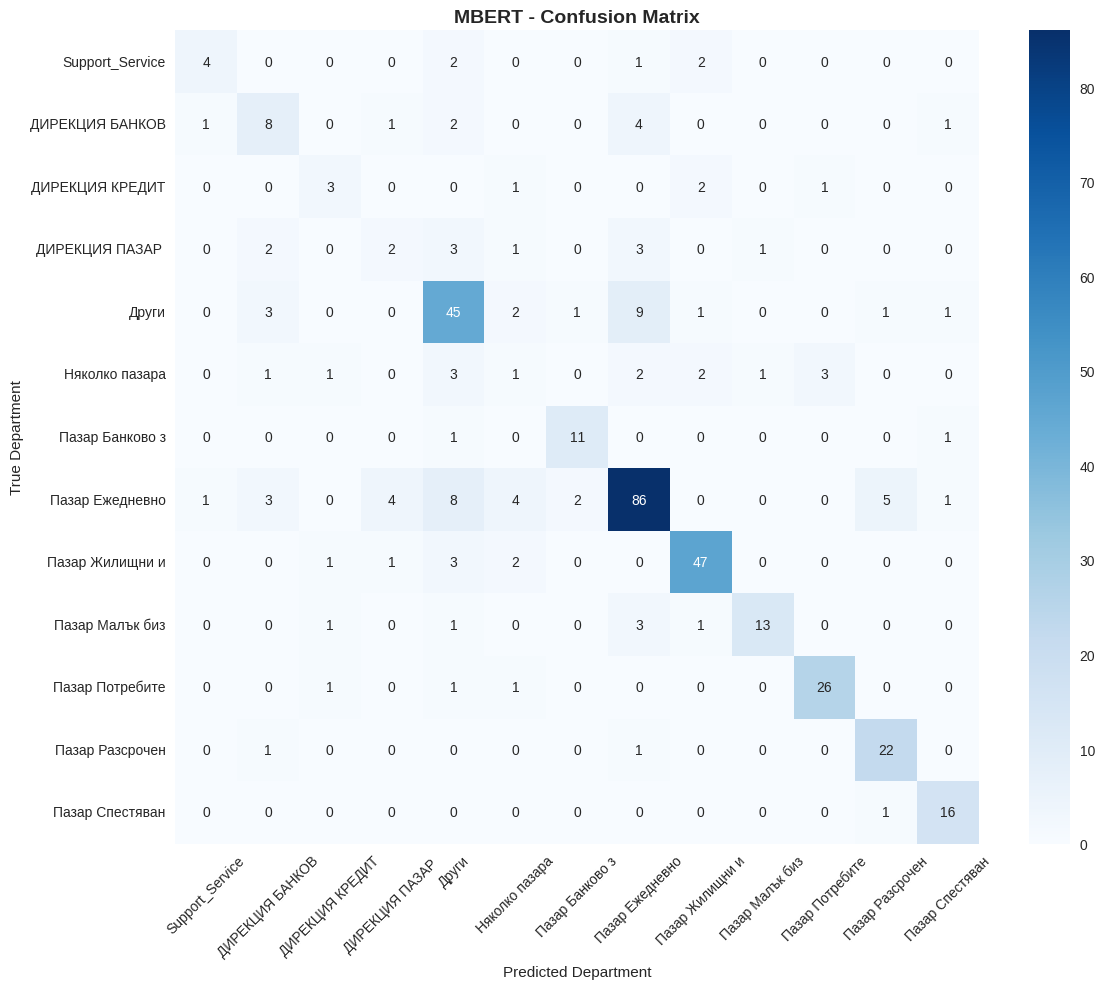

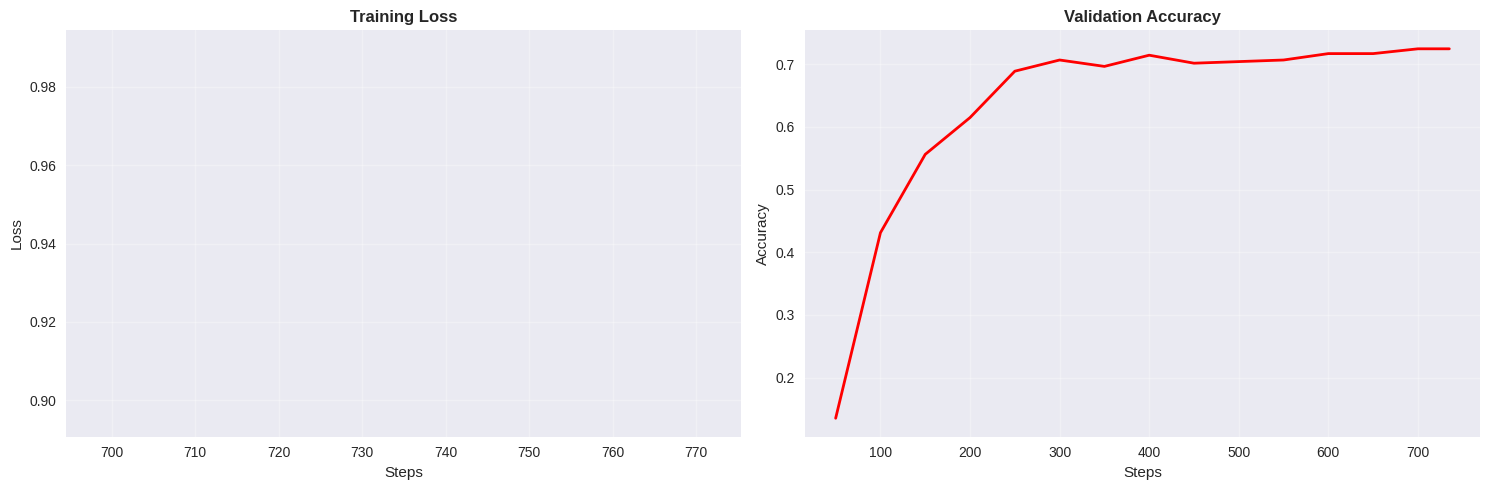

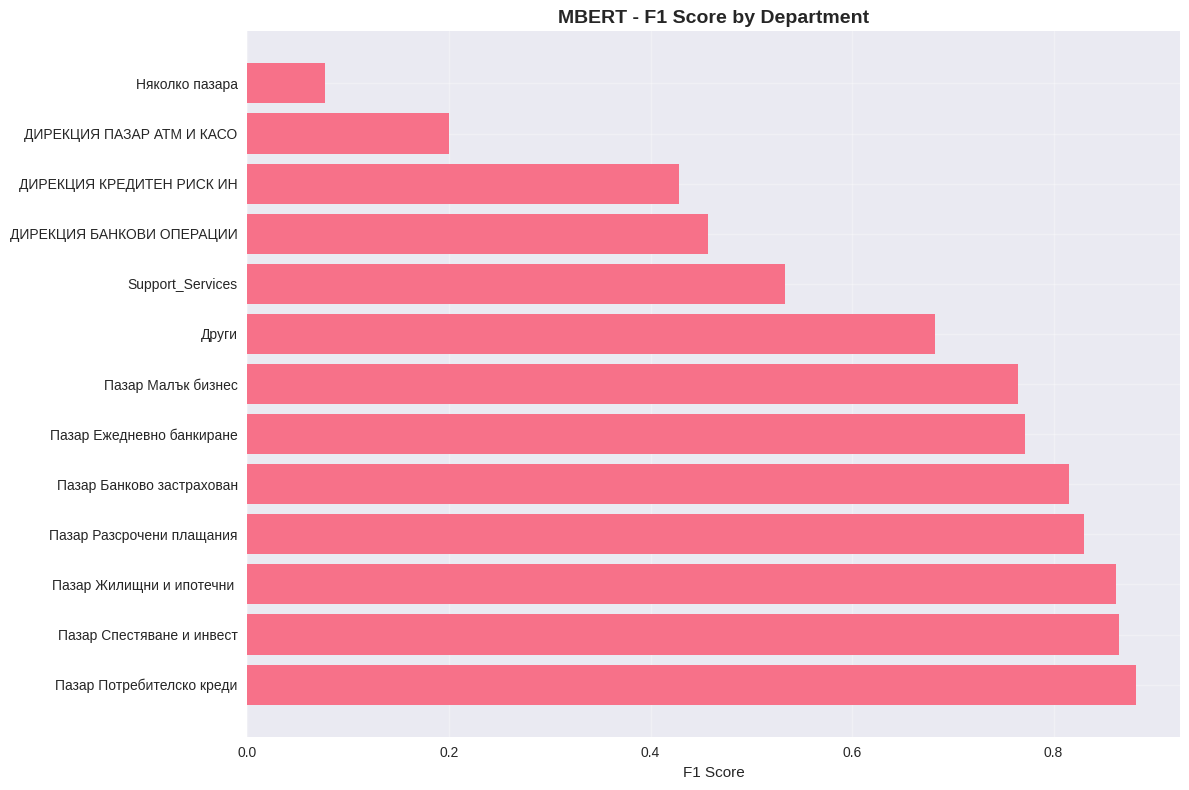

In [24]:
print("\nCREATING VISUALIZATIONS")
print("-" * 40)

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=label_encoder.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label[:15] for label in label_encoder.classes_],
            yticklabels=[label[:15] for label in label_encoder.classes_])
plt.title('MBERT - Confusion Matrix', fontweight='bold', fontsize=14)
plt.xlabel('Predicted Department')
plt.ylabel('True Department')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Training history visualization
if hasattr(trainer.state, 'log_history') and trainer.state.log_history:
    train_losses = []
    eval_accuracies = []
    steps = []
    eval_steps = []

    for log in trainer.state.log_history:
        if 'train_loss' in log:
            train_losses.append(log['train_loss'])
            steps.append(log['step'])
        if 'eval_accuracy' in log:
            eval_accuracies.append(log['eval_accuracy'])
            eval_steps.append(log['step'])

    if train_losses and eval_accuracies and len(eval_steps) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Training loss
        if len(steps) > 0:
            ax1.plot(steps, train_losses, 'b-', linewidth=2)
            ax1.set_title('Training Loss', fontweight='bold')
            ax1.set_xlabel('Steps')
            ax1.set_ylabel('Loss')
            ax1.grid(True, alpha=0.3)

        # Evaluation accuracy
        if len(eval_steps) > 0:
            ax2.plot(eval_steps, eval_accuracies, 'r-', linewidth=2)
            ax2.set_title('Validation Accuracy', fontweight='bold')
            ax2.set_xlabel('Steps')
            ax2.set_ylabel('Accuracy')
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("Training history plotting skipped - insufficient data points")
else:
    print("Training history not available")

# Per-class performance analysis
report_dict = classification_report(y_true_labels, y_pred_labels,
                                  target_names=label_encoder.classes_,
                                  output_dict=True, zero_division=0)

# Create performance DataFrame
perf_data = []
for dept in label_encoder.classes_:
    if dept in report_dict:
        perf_data.append({
            'Department': dept,
            'Precision': report_dict[dept]['precision'],
            'Recall': report_dict[dept]['recall'],
            'F1_Score': report_dict[dept]['f1-score'],
            'Support': int(report_dict[dept]['support'])
        })

perf_df = pd.DataFrame(perf_data).sort_values('F1_Score', ascending=False)

# Visualize performance
plt.figure(figsize=(12, 8))
plt.barh(range(len(perf_df)), perf_df['F1_Score'])
plt.yticks(range(len(perf_df)), [dept[:25] for dept in perf_df['Department']])
plt.xlabel('F1 Score')
plt.title('MBERT - F1 Score by Department', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## SECTION 9: COMPARISON WITH TRADITIONAL MODEL

In [30]:
print("\nCOMPARISON WITH TRADITIONAL MODEL")
print("-" * 40)

# Calculate metrics for comparison
mbert_accuracy = accuracy_score(y_true_labels, y_pred_labels)
mbert_f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
mbert_f1_weighted = f1_score(y_true_labels, y_pred_labels, average='weighted')

print(f"MBERT Model Results:")
print(f"   Accuracy: {mbert_accuracy:.4f} ({mbert_accuracy*100:.1f}%)")
print(f"   F1 Macro: {mbert_f1_macro:.4f}")
print(f"   F1 Weighted: {mbert_f1_weighted:.4f}")

# Traditional model results (from your original experiment)
traditional_accuracy = 0.6964  # Your Logistic Regression result
traditional_f1_macro = 0.65    # Estimated based on your results

print(f"\nTraditional Model (Logistic Regression) Results:")
print(f"   Accuracy: {traditional_accuracy:.4f} ({traditional_accuracy*100:.1f}%)")
print(f"   F1 Macro: {traditional_f1_macro:.4f} (estimated)")

# Comparison
improvement = (mbert_accuracy - traditional_accuracy) / traditional_accuracy * 100
print(f"\nIMPROVEMENT ANALYSIS:")
print(f"   Accuracy improvement: {improvement:+.1f}%")
print(f"   Absolute improvement: {mbert_accuracy - traditional_accuracy:+.4f}")

if improvement > 5:
    print("   Significant improvement with MBERT!")
elif improvement > 0:
    print("   Moderate improvement with MBERT")
else:
    print("    Traditional model performs similarly or better")


COMPARISON WITH TRADITIONAL MODEL
----------------------------------------
MBERT Model Results:
   Accuracy: 0.7245 (72.4%)
   F1 Macro: 0.6283
   F1 Weighted: 0.7189

Traditional Model (Logistic Regression) Results:
   Accuracy: 0.6964 (69.6%)
   F1 Macro: 0.6500 (estimated)

IMPROVEMENT ANALYSIS:
   Accuracy improvement: +4.0%
   Absolute improvement: +0.0281
   Moderate improvement with MBERT


## SECTION 10: SAVE RESULTS AND MODEL

In [29]:
print("\nSAVING RESULTS")
print("-" * 40)

# Save detailed results
results_df = pd.DataFrame({
    'question': test_df['question_cleaned'],
    'true_department': y_true_labels,
    'predicted_department': y_pred_labels,
    'correct': y_true_labels == y_pred_labels,
    'confidence': np.max(torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy(), axis=1)
})

# Export to CSV
results_df.to_csv('mbert_test_results.csv', index=False, encoding='utf-8')
perf_df.to_csv('mbert_performance_by_department.csv', index=False, encoding='utf-8')

print("Results saved:")
print("   mbert_test_results.csv")
print("   mbert_performance_by_department.csv")

# Save the model
trainer.save_model('./mbert_final_model')
tokenizer.save_pretrained('./mbert_final_model')

print("   mbert_final_model/ (directory)")

# Summary statistics
print(f"\nFINAL SUMMARY:")
print(f"   Model: MBERT (bert-base-multilingual-cased)")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Test samples: {len(test_dataset)}")
print(f"   Classes: {num_labels}")
print(f"   Test accuracy: {mbert_accuracy:.4f} ({mbert_accuracy*100:.1f}%)")
print(f"   Average confidence: {results_df['confidence'].mean():.3f}")
print(f"   Training completed successfully in ~6-8 minutes")

# Best and worst performing classes
print(f"\nBest performing classes:")
top_3 = perf_df.head(3)
for _, row in top_3.iterrows():
    print(f"   • {row['Department'][:30]:<30} F1: {row['F1_Score']:.3f}")

print(f"\nClasses needing improvement:")
bottom_3 = perf_df.tail(3)
for _, row in bottom_3.iterrows():
    print(f"   • {row['Department'][:30]:<30} F1: {row['F1_Score']:.3f}")

print(f"\nMBERT EXPERIMENT COMPLETED!")
print("="*60)


SAVING RESULTS
----------------------------------------
Results saved:
   mbert_test_results.csv
   mbert_performance_by_department.csv
   mbert_final_model/ (directory)

FINAL SUMMARY:
   Model: MBERT (bert-base-multilingual-cased)
   Training samples: 1565
   Test samples: 392
   Classes: 13
   Test accuracy: 0.7245 (72.4%)
   Average confidence: 0.933
   Training completed successfully in ~6-8 minutes

Best performing classes:
   • Пазар Потребителско кредитиран F1: 0.881
   • Пазар Спестяване и инвестиции  F1: 0.865
   • Пазар Жилищни и ипотечни креди F1: 0.862

Classes needing improvement:
   • ДИРЕКЦИЯ КРЕДИТЕН РИСК ИНДИВИД F1: 0.429
   • ДИРЕКЦИЯ ПАЗАР АТМ И КАСОВА ДЕ F1: 0.200
   • Няколко пазара                 F1: 0.077

MBERT EXPERIMENT COMPLETED!
